In [2]:
import pandas as pd
from tqdm import tqdm
from pandarallel import pandarallel
import matplotlib.pyplot as plt

pandarallel.initialize(progress_bar=True)

DATA_ROOT = '../data'

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
# Read in the data
df_db = pd.read_csv(f'../data/raw/test/Тестовый датасет ЦБ/Тестовый датасет 2 часть/DS_test6(2020-06--2022-08-01).csv', engine="pyarrow", delimiter='\t')
df_db.shape

(75989258, 4)

Чтобы охвтить общую информацию о продуктах и их тенденциях, мы предположили, что взяв случайные, мы получим примерно равномерный срез по категориям. Поэтому мы брали k случайных продуктов для каждого предсказания ИПЦ.

Чтобы еще сильнее улучшить предсказания модели, мы делали множество предсказаний ИПЦ с разными k, и усредняли их значение. В итоге нам получилось уменьшить ошибку (MSE, MAPE) модели вдвое по сравнению с первоначальным вариантом.


In [12]:
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75989258 entries, 0 to 75989257
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   WebPriceId    int64         
 1   DateObserve   datetime64[ns]
 2   StockStatus   object        
 3   CurrentPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.3+ GB


In [18]:
DATE_COLUMN = "DateObserve"
PRICE_COLUMN = "CurrentPrice"
ID_COLUMN = "WebPriceId"
STOCK_STATUS_COLUMN = "StockStatus"

In [19]:
# Remove webpriceids with less than 10 observations
# df_db = df_db.groupby(ID_COLUMN).filter(lambda x: len(x) > 10)

In [20]:
def select_data_in_between(df: pd.DataFrame, date_start: str = None, date_end: str = None) -> pd.DataFrame:
    """
    Select data between two dates
    """
    if date_start is None:
        date_start = df[DATE_COLUMN].min()
    if date_end is None:
        date_end = df[DATE_COLUMN].max()
    return df[(df[DATE_COLUMN] >= date_start) & (df[DATE_COLUMN] <= date_end)]

In [21]:
def find_nearest_to_date_in_series(series: pd.Series, date: str) -> pd.Series:
    """
    Find nearest date in a series
    """
    return series.iloc[(series - pd.to_datetime(date)).abs().argsort()[:1]]

In [22]:
# df_db = select_data_in_between(df_db, date_start="2022-06-01")

In [23]:
df_db.shape

(75989258, 4)

In [24]:
# Remove webpriceids with less than 10 observations
df_db = df_db[:].groupby(ID_COLUMN).filter(lambda x: len(x) >= 5)

In [25]:
df_db.shape

(57493695, 4)

In [249]:
import numpy as np

In [31]:
# Реализация бейзлайна
def baseline_prediction(df: pd.DataFrame, date: str, k: int = 5000, ids: list = None) -> float:
    """
        Предсказание ИПЦ для конца месяца, указанного в date,
        на основании данных до date. Среднее по ИПЦ всех отдельных
        товаров, рассчитывваемое по формуле

        ИПЦ = Цена в date / Цена в date - 1, но месяц назад

    Arguments:
        df: pd.DataFrame - все данные
        date: str - имеет формат "ГГГГ-ММ-ДД"
        k: int - лимит на количество товаров, по которым считается среднее

    Return:
        IPC: float - предсказанная ИПЦ за месяц

    """


    # Разбить date на текущий месяц, день и год
    year, month, day = date.split('-')

    # Выбрать данные от месяца назад до date, использовать pd.Timedelta
    df_month = select_data_in_between(df, date_start=pd.to_datetime(date) - pd.Timedelta(days=40), date_end=date)
    df_month = df_month[df_month[STOCK_STATUS_COLUMN] == "InStock"]

    # Отсеить WebPriceId, у которых меньше 3 записей за этот период
    if ids is None:
        ids = df_month.groupby(ID_COLUMN).filter(lambda x: len(x) > 3)[ID_COLUMN].unique()

    # Shuffle ids
    # Random choice of k*2 ids
    ids = np.random.choice(ids, k, replace=False)



    ipc_frame = pd.DataFrame()
    # Для каждого товара в промежутке посчитать ИПЦ
    total_drops = 0
    i = 0
    for web_price_id in tqdm(ids, total=min(len(ids), k)):
        # Если достигнут лимит, то прервать цикл
        if k != 0 and i >= k + total_drops:
            break
        i += 1

        # Выбрать данные по WebPriceId
        df_id = df_month[df_month[ID_COLUMN] == web_price_id]

        # Найти ближайшую стоимость к date и к date - 1 месяц
        nearest_date = find_nearest_to_date_in_series(df_id[DATE_COLUMN], date)
        nearest_date_prev = find_nearest_to_date_in_series(df_id[DATE_COLUMN], pd.to_datetime(date) - pd.Timedelta(days=45))

        # Если nearest_date или nearest_date_prev пустые, то пропустить товар
        if nearest_date.empty or nearest_date_prev.empty:
            continue

        # Отсеить товар, если между краевыми датами меньше 25 дней
        days_in_between = (pd.to_datetime(nearest_date.values[0]) - pd.to_datetime(nearest_date_prev.values[0])).days
        if days_in_between < 10:
            # print('drop: ', days_in_between)
            total_drops += 1
            continue

        # Выбрать стоимость по ближайшей дате
        price = df_id[df_id[DATE_COLUMN] == nearest_date.values[0]][PRICE_COLUMN].values[0]
        price_prev = df_id[df_id[DATE_COLUMN] == nearest_date_prev.values[0]][PRICE_COLUMN].values[0]
        interval = days_in_between

        # Посчитать ИПЦ
        ipc_frame = pd.concat([ipc_frame, pd.DataFrame([[web_price_id, price, price_prev, interval]])])

        # Поправка на интервал между датами
        # ipc = ipc ** (30 / days_in_between)

    try:
        ipc_frame['ipc'] = ipc_frame.apply(lambda x: (x[1] / x[2] * (30/interval)) - 1, axis=1)
        return ipc_frame['ipc'].mean(), total_drops
    except:
        return 0, -1

baseline_prediction(df_db, '2022-07-21', k=3000)


NameError: name 'np' is not defined

In [27]:
ids = df_db.groupby(ID_COLUMN).filter(lambda x: len(x) > 3)[ID_COLUMN].unique()


In [28]:
def cyclic_prediction(k, times, df, date, ids):
    pred_results =[  baseline_prediction(df, date, k=k, ids=ids)[0] for i in range(1,times) ]
    return np.mean(pred_results), pred_results

# mean, results = cyclic_prediction(k=5000, times=5, df=df_db, date='2022-07-21', ids=ids)
# for r in results:
#     resultses.append(r)




In [253]:
resultses = []
resultses_means = []
date = '2022-08-01'
print(resultses_means)
resultses.append(cyclic_prediction(k=750, times=15, df=df_db, date=date, ids=ids)[1])
resultses_means.append(np.mean(resultses))
resultses.append(cyclic_prediction(k=5000, times=5, df=df_db, date=date, ids=ids)[1])
resultses_means.append(np.mean(resultses))
resultses.append(cyclic_prediction(k=3000, times=10, df=df_db, date=date, ids=ids)[1])
resultses_means.append(np.mean(resultses))
resultses.append(cyclic_prediction(k=1000, times=10, df=df_db, date=date, ids=ids)[1])
resultses_means.append(np.mean(resultses))
resultses.append(cyclic_prediction(k=1000, times=10, df=df_db, date=date, ids=ids)[1])
resultses_means.append(np.mean(resultses))



[]


100%|██████████| 5000/5000 [00:24<00:00, 204.16it/s]
/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
100%|██████████| 3000/3000 [00:14<00:00, 200.62it/s]
/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
100%|██████████| 1000/1000 [00:04<00:00, 200.57it/s]
/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:163: V

In [255]:
resultses_means = [np.mean(resultses[:15]), np.mean(resultses[:20]), np.mean(resultses[:30]), np.mean(resultses[:40]), np.mean(resultses[:50])]

In [257]:
resultses_means

[0.485747922478852,
 0.47382154960319756,
 0.41735062552691526,
 0.40984717660742176,
 0.3996047535311654]

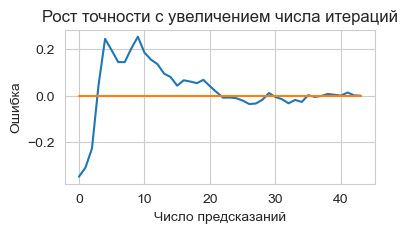

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

data = [0.05884139447426373, 0.1361979153219224, 0.34466663540943654, 1.2646117699740382, 1.4429734282210698, 0.3567796480451227, 0.24471436276581798, 0.5491422357740001, 1.0756022922448836, 1.1120179930243317, -0.08615950077178516, 0.22535794647074578, 0.30837200332371434, -0.02588413281045645, 0.27898484571567506, -0.10393423174076706, 0.8412947078940167, 0.3729550744768662, 0.3357468180811254, 0.7441497861699312, -0.0990366853458008, -0.10493779773722532, -0.12884130520868878, 0.4085033656307455, 0.33634837428087033, 0.1179455299679844, -0.008088939170520427, 0.4285257971129856, 0.840487365406369, 1.2531820688067838, -0.1062350374075101, 0.09042687867843653, -0.18433431308897325, 0.8640515491001036, 0.08483103581908627, 1.4281435120903718, 0.1215179531950414, 0.5678741033318261, 0.7315472243170056, 0.2755453924540273, 0.2653515427476568, 0.9675129358211633, -0.11502083738272807, 0.35176288331004835, 0.1187203201094374]
data_means = [np.mean(data[:i]) for i in range(1, len(data))]
# Set figsize
plt.figure(figsize=(4, 2))
plt.plot(data_means - data_means[-1])
plt.plot([0 for i in range(1, len(data))])
plt.title("Рост точности с увеличением числа итераций")
plt.ylabel("Ошибка")
plt.xlabel("Число предсказаний")
plt.show()

In [259]:
# unppack resultses
resultses_copy = resultses.copy()

# resultses = [result for sublist in resultses for result in sublist]

print(resultses)
print(np.mean(resultses))


[0.05884139447426373, 0.1361979153219224, 0.34466663540943654, 1.2646117699740382, 1.4429734282210698, 0.3567796480451227, 0.24471436276581798, 0.5491422357740001, 1.0756022922448836, 1.1120179930243317, -0.08615950077178516, 0.22535794647074578, 0.30837200332371434, -0.02588413281045645, 0.27898484571567506, -0.10393423174076706, 0.8412947078940167, 0.3729550744768662, 0.3357468180811254, 0.7441497861699312, -0.0990366853458008, -0.10493779773722532, -0.12884130520868878, 0.4085033656307455, 0.33634837428087033, 0.1179455299679844, -0.008088939170520427, 0.4285257971129856, 0.840487365406369, 1.2531820688067838, -0.1062350374075101, 0.09042687867843653, -0.18433431308897325, 0.8640515491001036, 0.08483103581908627, 1.4281435120903718, 0.1215179531950414, 0.5678741033318261, 0.7315472243170056, 0.2755453924540273, 0.2653515427476568, 0.9675129358211633, -0.11502083738272807, 0.35176288331004835, 0.1187203201094374]
0.3996047535311654


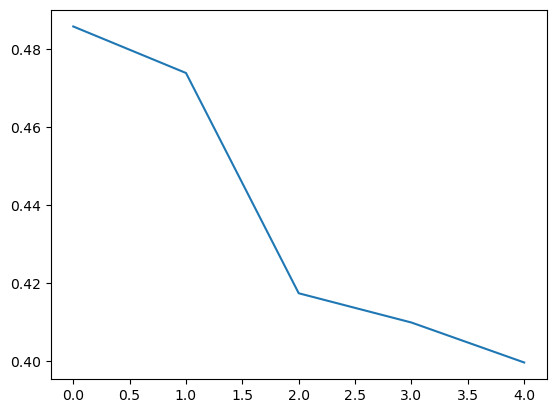

In [260]:
# Plot result means
plt.plot(resultses_means)
plt.show()

In [205]:
# remove inf from resultses
resultses = [x for x in resultses if x != np.inf]

# Check y_train


In [26]:
# Evaluate baseline

# Load test data
def read_xlsx(path):
    df = pd.read_excel(path, engine='openpyxl')
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    # drop index
    df = df.reset_index(drop=True)

    return df

# read data
df_y_train = read_xlsx(f"../data/raw/Y_train.xlsx")
df_y_train.head()


"ИПЦ, мом",Период,Целевой показатель
0,2020-06-01 00:00:00,0.28
1,2020-07-01 00:00:00,-0.065
2,2020-08-01 00:00:00,-0.005
3,2020-09-01 00:00:00,0.315
4,2020-10-01 00:00:00,0


In [35]:
import numpy as np

In [39]:
# For each date in df_y_train, calculate baseline prediction
df_y_train["predict"] = df_y_train["Период"].parallel_apply(lambda x: cyclic_prediction(k=500, times=10, df=df_db, date=x.strftime("%Y-%m-%d"), ids=ids)[0])


100%|██████████| 500/500 [00:02<00:00, 223.33it/s]


In [49]:
# drop df_y_train rows with inf
df_y_train = df_y_train[df_y_train["mape"] != np.inf]


In [56]:
df_y_train

"ИПЦ, мом",Период,Целевой показатель,predict,mape
0,2020-06-01 00:00:00,0.28,0.000000,1.000000
1,2020-07-01 00:00:00,-0.065,0.000000,-1.000000
5,2020-11-01 00:00:00,0.375,0.590686,0.575163
6,2020-12-01 00:00:00,0.35,0.927677,1.650505
7,2021-01-01 00:00:00,0.38,0.924201,1.432107
8,2021-02-01 00:00:00,0.685,0.488659,0.286629
9,2021-03-01 00:00:00,0.255,0.283215,0.110645
11,2021-05-01 00:00:00,0.485,1.309143,1.699263
12,2021-06-01 00:00:00,0.25,0.298085,0.192338
13,2021-07-01 00:00:00,-0.135,0.632819,-5.687550


In [57]:
# Calculate MAPE
df_y_train["mape"] = df_y_train.apply(lambda x: np.abs(x["predict"] - x["Целевой показатель"]) / x["Целевой показатель"], axis=1)
df_y_train["mape"].mean()

0.2974055188795553

In [58]:
# Calculate MSE
df_y_train["mse"] = df_y_train.apply(lambda x: (x["predict"] - x["Целевой показатель"]) ** 2, axis=1)
df_y_train["mse"].mean()

0.5204604867897418

In [42]:
adaptive = read_xlsx(f"../data/raw/Y_train_adaptive.xlsx")
adaptive.mean()

/tmp/ipykernel_2983366/759320144.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  adaptive.mean()


ИПЦ, мом
Целевой показатель (для проверки адаптивности)    0.925417
dtype: float64